##Customer segmentation with Python


In [0]:
''' Ref: 
[1] Practical Machine Learning with Python: A Problem-Solver's Guide to Building Real-World Intelligent Systems. Book by Dipanjan Sarkar, Raghav Bali, and Tushar Sharma
[2] https://en.wikipedia.org/wiki/RFM_(customer_value)
[3] https://academy.acommerce.asia/%E0%B9%80%E0%B8%97%E0%B8%84%E0%B8%99%E0%B8%B4%E0%B8%84-rfm-%E0%B8%81%E0%B8%B1%E0%B8%9A%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%9E%E0%B8%B1%E0%B8%92%E0%B8%99%E0%B8%B2-email-marketing/
[4] https://www.mne.psu.edu/cimbala/me345/Lectures/Probability_density_functions.pdf
[5] https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster (Help me alot)
'''

" Ref: \n[1] Practical Machine Learning with Python: A Problem-Solver's Guide to Building Real-World Intelligent Systems. Book by Dipanjan Sarkar, Raghav Bali, and Tushar Sharma\n[2] https://en.wikipedia.org/wiki/RFM_(customer_value)\n[3] https://academy.acommerce.asia/%E0%B9%80%E0%B8%97%E0%B8%84%E0%B8%99%E0%B8%B4%E0%B8%84-rfm-%E0%B8%81%E0%B8%B1%E0%B8%9A%E0%B8%81%E0%B8%B2%E0%B8%A3%E0%B8%9E%E0%B8%B1%E0%B8%92%E0%B8%99%E0%B8%B2-email-marketing/\n[4] https://www.mne.psu.edu/cimbala/me345/Lectures/Probability_density_functions.pdf\n[5] https://stackoverflow.com/questions/28227340/kmeans-scatter-plot-plot-different-colors-per-cluster (Help me alot)\n"

In [0]:
# # Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# link = 'https://drive.google.com/open?id=1gOjk-2taMUekp_EyxkWXuNDViMUJD3DB'

# fluff, id = link.split('=')
# print (id) # Verify that you have everything after '='
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('Online Retail.xlsx') 

In [0]:
!git clone https://github.com/dipanjanS/practical-machine-learning-with-python.git

Cloning into 'practical-machine-learning-with-python'...
remote: Enumerating objects: 1446, done.
remote: Total 1446 (delta 0), reused 0 (delta 0), pack-reused 1446
Receiving objects: 100% (1446/1446), 118.41 MiB | 23.57 MiB/s, done.
Resolving deltas: 100% (427/427), done.
Checking out files: 100% (491/491), done.


In [0]:
cd practical-machine-learning-with-python/notebooks/Ch08_Customer_Segmentation_and_Effective_Cross_Selling/

/content/practical-machine-learning-with-python/notebooks/Ch08_Customer_Segmentation_and_Effective_Cross_Selling


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import math
import matplotlib.mlab as mlab 
import seaborn as sns
from sklearn import preprocessing as pp
# %matplotlib inline => this command will make our graph in line but not good for black theme 

In [0]:
start = time.time()

pd_df = pd.read_excel('Online Retail.xlsx')

end = time.time()
print(end - start)

45.97753977775574


##<font color = lightpink >Data understanding and Data exploration</font>  
### ( ु⁎ᴗ_ᴗ⁎)ु.｡oO    
### Before do anything don't forget to duplicate the data first.

In [0]:
pd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [0]:
# Explore volumes of sales for those countries
# The more number of oreder, larger effect in business
vol_of_sales = pd_df.Country.value_counts().reset_index()
vol_of_sales.head(10)
# See visualization via tableau

,index,Country
0,United Kingdom,495478
1,Germany,9495
2,France,8557
3,EIRE,8196
4,Spain,2533
5,Netherlands,2371
6,Belgium,2069
7,Switzerland,2002
8,Portugal,1519
9,Australia,1259


In [0]:
for i in range(len(pd_df.columns)):
    name = pd_df.columns[i]
    real = pd_df[:][name].unique().shape
    print('{0} : {1}'.format(name, real))

InvoiceNo : (25900,)
StockCode : (4070,)
Description : (4224,)
Quantity : (722,)
InvoiceDate : (23260,)
UnitPrice : (1630,)
CustomerID : (4373,)
Country : (38,)


In [0]:
# the sign - means someone have already got refund. So, we need to handle the minus value.  
pd_df.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

####<font color = lightblue > What I got from this part: A lot  items were ordered from UK. So, in this case we will focus on UK . Another probelm we known is the data contain MINUS value as refund. </font>

##<font color = lightpink > Data Preparation [Cleaning + Feature engineering] </font>
###୧( ಠ Д ಠ )୨

##<font color = lightpink > Cleaning

In [0]:
pd_df['amount'] = pd_df.Quantity*pd_df.UnitPrice        # Add amount column
pd_df = pd_df[~(pd_df.amount<0)]                     # Remove negative or return transactions
pd_df_uk = pd_df[pd_df.Country == 'United Kingdom']     # For our case we will concern only UK
pd_df_uk = pd_df_uk[~(pd_df_uk.CustomerID.isnull())] # Filtering not null customers

In [0]:
pd_df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 9 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null datetime64[ns]
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
amount         354345 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.0+ MB


In [0]:
pd_df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354345 entries, 0 to 541893
Data columns (total 9 columns):
InvoiceNo      354345 non-null object
StockCode      354345 non-null object
Description    354345 non-null object
Quantity       354345 non-null int64
InvoiceDate    354345 non-null datetime64[ns]
UnitPrice      354345 non-null float64
CustomerID     354345 non-null float64
Country        354345 non-null object
amount         354345 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 27.0+ MB


##<font color = lightpink > Feature Engineering </font>
*   [R] Recency – How recently did the customer purchase?
*   [F] Frequency – How often do they purchase?
*   [M] Monetary Value – How much do they spend?
    
โดยเราอาจจะส่งแคมเปญที่ต่างกันไปแบบนี้
1.   Recency ↑ , Frequency 	↑ , Monetary	↑ : ให้ความสำคัญกับลูกค้าที่สุดพิเศษ เช่น เสนอสิทธิ์ส่งฟรี เป็นต้น
2.   Recency 	↑, Frequency 	↓ , Monetary 	↓ : ในส่วนนี้จะรวมไปถึงลูกค้าใหม่ด้วย เราต้องสร้างความประทับใจแรก เช่น โปรโมชันต้อนรับ หรือทริคในการใช้สินค้าของเรา หรือข้อมูลอื่นๆที่เป็นประโยชน์แก่ลูกค้าใหม่ เป็นต้น
3. Recency 	↓ , Frequency 	↓ , Monetary 	↓ : อาจจะส่ง re-opt-in แคมเปญไปให้ และเช็กว่าลูกค้ายังสนใจเราอยู่หรือไม่

In [0]:
''' R: recency '''
'''we need to find the reference date to compare to when customers ordered at last time. So, we will find time of last order first.'''

last_order = pd_df_uk.InvoiceDate.max()
ref_date = last_order + datetime.timedelta(days = 1) # timedelta object represents the difference between two dates or times.
# # so now we be able to count the last order by
# ref_date - last_order # one day ago. 
pd_df_uk['days_since_last_purchase'] = ref_date - pd_df_uk.InvoiceDate # calculate for whole table
pd_df_uk['days_since_last_purchase_num'] = pd_df_uk['days_since_last_purchase'].astype('timedelta64[D]') # remove some infor from days_since_last_purchase

customer_history_df_uk = pd_df_uk.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
customer_history_df_uk = customer_history_df_uk.rename(columns={'days_since_last_purchase_num':'recency'})


''' F: Frequency '''
customer_freq = pd_df_uk[['CustomerID', 'amount']].groupby("CustomerID").count().reset_index() # reset in dex is necessary to create an index for merge
customer_freq.rename(columns = {'amount':'frequency'} , inplace = True)


''' M: Monetary as Amount'''
customer_monetary = pd_df_uk[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()


'''Merge R-F-M All sector combine'''
customer_history_df_uk = customer_history_df_uk.merge(customer_freq, how ='outer').merge(customer_monetary, how = 'outer')
customer_history_df_uk.amount = customer_history_df_uk.amount+0.001 # for log trasform later

# customer_history_df_uk = pd_df_uk.groupby("CustomerID").min().reset_index()[['CustomerID', 'days_since_last_purchase_num']]
# Why we could not run when replace pd_df_uk[['CustomerID']] with pd_df_uk['CustomerID']
# ans type(pd_df_uk[['CustomerID']])  =>  DataFrame, 
#     type(pd_df_uk['CustomerID'])    =>   Series

In [0]:
customer_history_df_uk.head()

,CustomerID,recency,frequency,amount
0,12346.0,326.0,1,77183.601
1,12747.0,2.0,103,4196.011
2,12748.0,1.0,4596,33719.731
3,12749.0,4.0,199,4090.881
4,12820.0,3.0,59,942.341


In [0]:
customer_history_df_uk.describe()

,CustomerID,recency,frequency,amount
count,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,92.188472,90.371079,1863.911113
std,1576.823683,99.528995,217.796155,7481.922217
min,12346.000000,1.000000,1.000000,0.001000
25%,14208.000000,18.000000,17.000000,300.041000
50%,15569.000000,51.000000,41.000000,651.821000
75%,16913.000000,143.000000,99.000000,1575.891000
max,18287.000000,374.000000,7847.000000,259657.301000


In [0]:
type(customer_history_df_uk)

pandas.core.frame.DataFrame

Remark:
1. The return value is a tuple (n, bins, patches) or ([n0, n1, ...], bins, [patches0, patches1,...]) if the input contains multiple data.
2. bins =  the number of bars you want to show in your histogram plot.
3. patches object. This gives us access to the properties of the objects drawn like color of each line(bar)
4. <font color = lightgreen >Distribution we got is not NORMAL !!! ( We have to deal with Skewed distribution) 


Probability density function – In simple terms, a probability density function (PDF) is constructed by drawing a smooth curve fit through the vertically normalized histogram as sketched. You can think of a PDF as the smooth limit of a vertically normalized histogram if there were millions of
measurements and a huge number of bins.

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, '$\\mathrm{Histogram\\ of\\ sales\\ recency}\\ $')

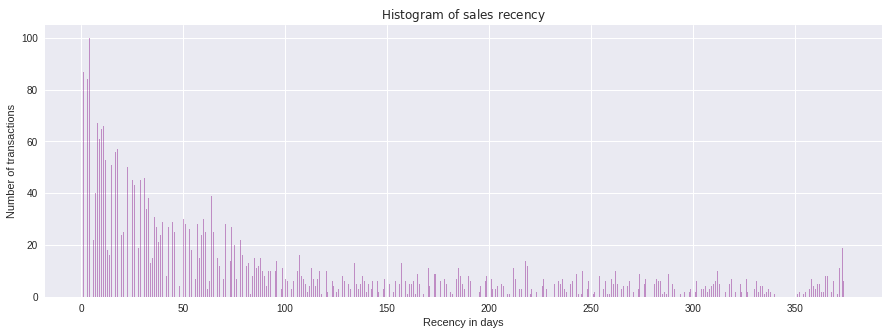

In [0]:
fig = plt.gcf()
fig.set_size_inches(15, 5)
sns.distplot(customer_history_df_uk.recency, bins = 1000, kde = False, color = 'purple')
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')


# '''Plot Histogram for R feature (original)'''

# plt.figure(figsize = [15,5])
# x = customer_history_df_uk.recency
# mean = np.mean(x)
# sd = math.sqrt(np.var(x))
# n , bins , patches = plt.hist(x, 1000, facecolor='purple', alpha=0.75)
# y = mlab.normpdf(bins, mean, sd) # matplotlib.mlab.normpdf(x, *args= mu, sd)
# plt.xlabel('Recency in days')
# plt.ylabel('Number of transactions')
# plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
# l = plt.plot(bins, y,'--r', linewidth=2)

In [0]:
# Auto log transform; run only once!!!

log_feature = 'log_'+customer_history_df_uk.columns[:]
till = customer_history_df_uk.columns[:].shape[0]
for i in range(1, till):
        customer_history_df_uk[log_feature[i]] = customer_history_df_uk.loc[:,customer_history_df_uk.columns[i]].apply(math.log)
# customer_history_df_uk.drop(columns= ['log_recency','log_frequency','log_amount']) # for deleting

In [0]:
customer_history_df_uk.describe()
#customer_history_df_uk.drop(columns= ['log_recency','log_frequency','log_amount'])

,CustomerID,recency,frequency,amount,log_recency,log_frequency,log_amount
count,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000,3921.000000
mean,15561.471563,92.188472,90.371079,1863.911113,3.763710,3.661330,6.539777
std,1576.823683,99.528995,217.796155,7481.922217,1.433644,1.339529,1.265332
min,12346.000000,1.000000,1.000000,0.001000,0.000000,0.000000,-6.907755
25%,14208.000000,18.000000,17.000000,300.041000,2.890372,2.833213,5.703919
50%,15569.000000,51.000000,41.000000,651.821000,3.931826,3.713572,6.479770
75%,16913.000000,143.000000,99.000000,1575.891000,4.962845,4.595120,7.362576
max,18287.000000,374.000000,7847.000000,259657.301000,5.924256,8.967887,12.467118


In [0]:
log_data = customer_history_df_uk[log_feature[1:]].as_matrix() # since log_feature contains lof_customerID which we don't need to use, we chosen[1:] to convert data frame to matrix
normalizer = pp.StandardScaler().fit(log_data)
norm_log_data = normalizer.transform(log_data)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


Text(0.5, 1.0, 'histrogram of Log transformed customer monetary value')

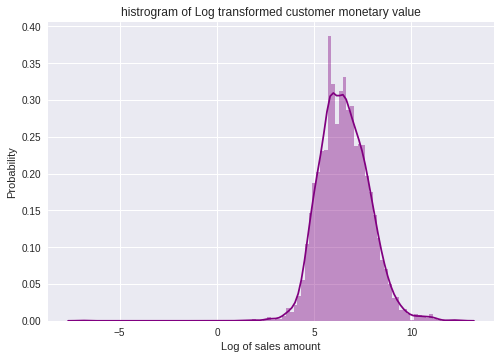

In [0]:
sns.distplot(customer_history_df_uk.log_amount, bins=100, color = 'purple')
plt.xlabel('Log of sales amount')
plt.ylabel('Probability')
plt.title('histrogram of Log transformed customer monetary value')

## original
# x = customer_history_df_uk.log_amount
# n, bins, patches = plt.hist(x, 1000, facecolor = 'purple', alpha = 0.75)
# plt.xlabel('Log of sales amount')
# plt.ylabel('Probability')
# plt.title('histrogram of Log transformed customer monetary value')
# plt.show()

Text(0.5, 0, 'Monetary')

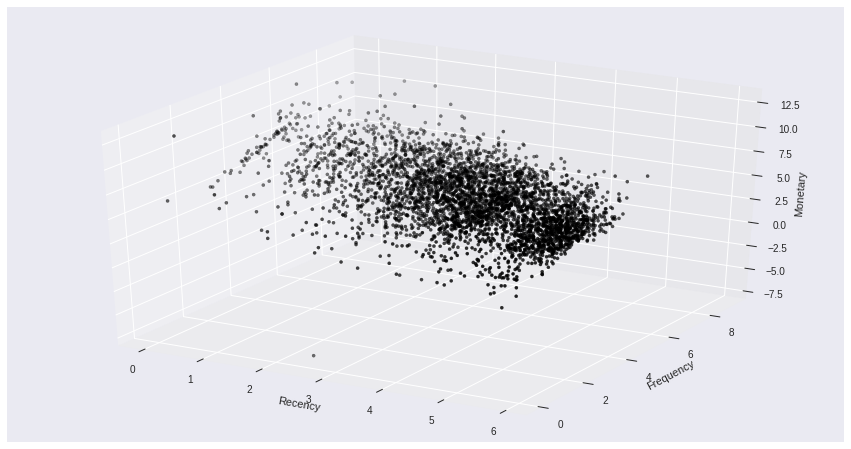

In [0]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111,projection='3d')

xs = customer_history_df_uk.log_recency
ys = customer_history_df_uk.log_frequency
zs = customer_history_df_uk.log_amount
ax.scatter(xs, ys, zs, s=10, c = 'black')

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

In [0]:
customer_history_df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3921 entries, 0 to 3920
Data columns (total 7 columns):
CustomerID       3921 non-null float64
recency          3921 non-null float64
frequency        3921 non-null int64
amount           3921 non-null float64
log_recency      3921 non-null float64
log_frequency    3921 non-null float64
log_amount       3921 non-null float64
dtypes: float64(6), int64(1)
memory usage: 405.1 KB


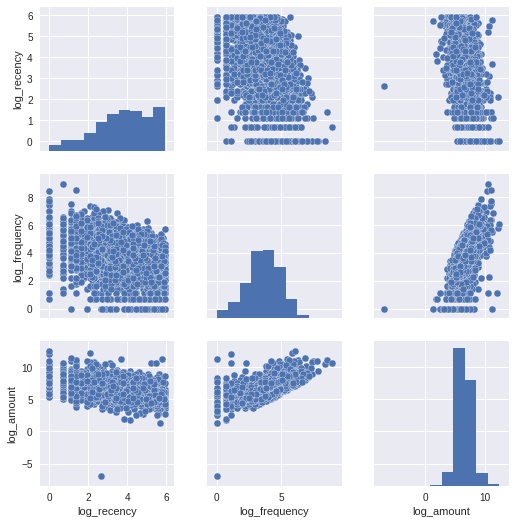

In [0]:
# multivariate correlation

sns.pairplot(customer_history_df_uk.loc[:,customer_history_df_uk.columns[4:7]])

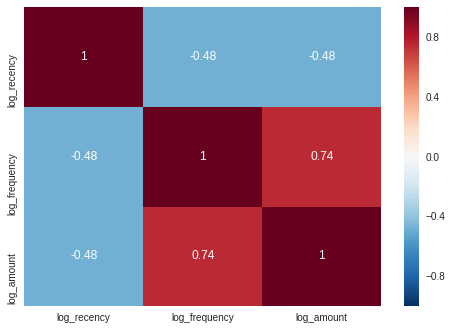

In [0]:
_pivot1 = customer_history_df_uk.loc[:,customer_history_df_uk.columns[4:7]]
corr_eff = _pivot1.corr()
sns.heatmap(corr_eff, annot=True)

In [0]:
from sklearn.cluster import KMeans
X = customer_history_df_uk.loc[:,customer_history_df_uk.columns[4:7]]
kmeans = KMeans(n_clusters=3, random_state=0, max_iter=1000)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

In [0]:
LABEL_COLOR_MAP = {0 : 'm',
                   1 : 'green',
                   2 : 'c' }

label_color = [LABEL_COLOR_MAP[l] for l in labels]

Text(0.5, 0, 'Monetary')

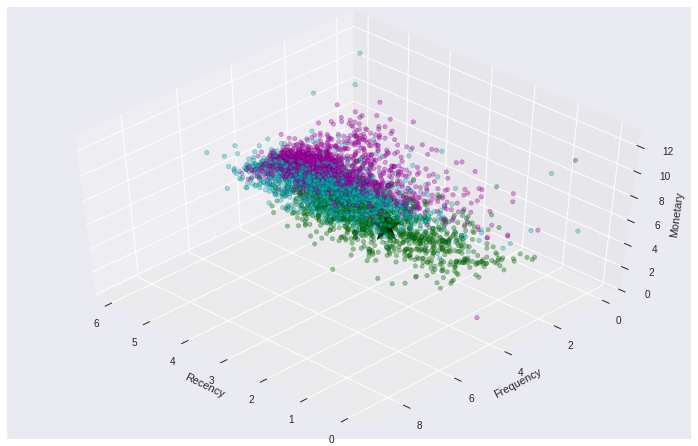

In [0]:
fig = plt.figure(figsize=(10, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
X_0 = X.iloc[:,0]
X_1 = X.iloc[:,1]
X_2 = X.iloc[:,2]
C_0 = centers[:,0]
C_1 = centers[:,1]
C_2 = centers[:,2]

ax.scatter(X_0, X_1, X_2, c = label_color , edgecolor='k', alpha = 0.4)
ax.scatter(centers[:,0], centers[:,1], centers[:,2],  s = 1000, c = 'k', marker='*', label = 'Centroid')
ax.set_zlim(0, 13)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

Text(0.5, 0, 'Monetary')

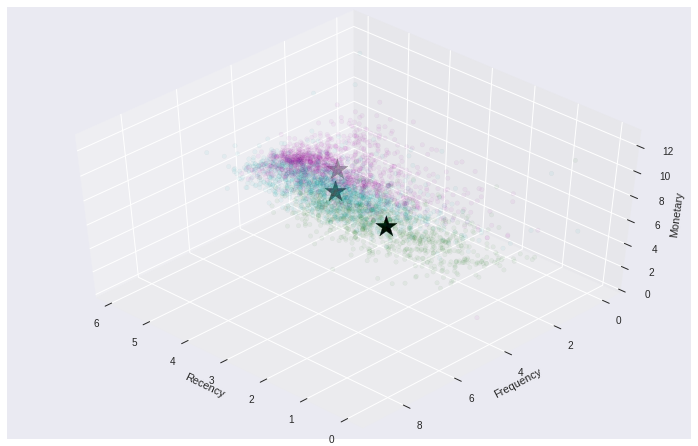

In [0]:
fig = plt.figure(figsize=(10, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
X_0 = X.iloc[:,0]
X_1 = X.iloc[:,1]
X_2 = X.iloc[:,2]
C_0 = centers[:,0]
C_1 = centers[:,1]
C_2 = centers[:,2]

ax.scatter(X_0, X_1, X_2, c = label_color , edgecolor='k', alpha = 0.05)
ax.scatter(centers[:,0], centers[:,1], centers[:,2],  s = 500, c = 'k', marker='*', label = 'Centroid')
ax.set_zlim(0, 13)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

โดยเราอาจจะส่งแคมเปญที่ต่างกันไปแบบนี้
1.   Recency ↑ , Frequency 	↑ , Monetary	↑ : ให้ความสำคัญกับลูกค้าที่สุดพิเศษ เช่น เสนอสิทธิ์ส่งฟรี เป็นต้น
2.   Recency 	↑, Frequency 	↓ , Monetary 	↓ : ในส่วนนี้จะรวมไปถึงลูกค้าใหม่ด้วย เราต้องสร้างความประทับใจแรก เช่น โปรโมชันต้อนรับ หรือทริคในการใช้สินค้าของเรา หรือข้อมูลอื่นๆที่เป็นประโยชน์แก่ลูกค้าใหม่ เป็นต้น
3. Recency 	↓ , Frequency 	↓ , Monetary 	↓ : อาจจะส่ง re-opt-in แคมเปญไปให้ และเช็กว่าลูกค้ายังสนใจเราอยู่หรือไม่

In [0]:
print(C_0)
print(C_1)
print(C_2)

[4.84984931 1.90791128 3.84052938]
[2.35673864 5.08424061 3.99169192]
[5.40462932 7.9475012  6.73830226]


In [0]:
# recheck
X_0.describe() == customer_history_df_uk.log_recency.describe()

count    True
mean     True
std      True
min      True
25%      True
50%      True
75%      True
max      True
Name: log_recency, dtype: bool

In [0]:
X_1.describe() == customer_history_df_uk.log_frequency.describe()

count    True
mean     True
std      True
min      True
25%      True
50%      True
75%      True
max      True
Name: log_frequency, dtype: bool

In [0]:
X_2.describe() == customer_history_df_uk.log_amount.describe()

count    True
mean     True
std      True
min      True
25%      True
50%      True
75%      True
max      True
Name: log_amount, dtype: bool

In [0]:
# customer_history_df_uk.to_csv('test2.csv')
# from google.colab import files
# files.download('test2.csv')

In [0]:
vol_of_sales.to_csv('vol_of_sales.csv')
from google.colab import files
files.download('vol_of_sales.csv')